# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 мая 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 мая, -4 балла после 06:00 13 мая, -6 баллов после 06:00 20 мая -8 баллов  после 06:00 27 мая


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (5 баллов)

###### Боевое применение (3 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [24]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать агломеративную кластеризацию. 

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Как считать расстояние $\|\mathbf{x} -\mathbf{x}' \|$ между объектами Вы должны выбрать сами.  Вы должны четко понимать, что выбор расстояния между объектами - самое важное в такого рода алгоритмах. Передавайте название расстояния в конструктор класса, а потом, в зависимости от названия, применяете ту или иную функцию для подсчета расстояния. 



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



Всего существует $k^N$ способов разбить N элементов на k кластеров, на каждой новой итерации алгоритма мы создаем новое разбиение на классы, которое основано только на старом разбиении. Очевидно, что либо разбиение сохранится, и тогда оно уже не изменится никогда, либо же изменится, и значение функционала уменьшится. 
У нас невозможно, чтоб одно и то же разбиение присутствовало дважды не подряд (т.е. был цикл длины >1), так как иначе одному и тому же разбиению соответствует различный функционал. Следовательно, сходится на конечное число операций, меньших $k^N$

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



Правдоподобие ограничено

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




Докажем для минимума.
Пусть $d_{\min}(U, S) >= d_{\min}(V, S)$

Тогда $| d_{\min}(U, S) - d_{\min}(V, S) | = d_{\min}(U, S) - d_{\min}(V, S) $

Следовательно, $\frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} (d_{\min}(U, S) - d_{\min}(V, S)) = d_{\min}(V, S)$



Пусть $d_{\min}(U, S) < d_{\min}(V, S)$

Тогда $| d_{\min}(U, S) - d_{\min}(V, S) | = d_{\min}(V, S) - d_{\min}(U, S) $

Следовательно, $\frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} (d_{\min}(V, S) - d_{\min}(U, S)) = d_{\min}(U, S)$

Для максимума аналогично.

# Реализация алгоритма кластеризации  (5 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [371]:
from sklearn.base import BaseEstimator, ClusterMixin
import copy

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, metric='euclidean', linkage='single', k=2):
        """
        metric - string with name of metric, for example, euclidean
        Please add necessary algoritm parameters to class constructor.
        """
        self.answer = []
        self.k = k
        
        if metric == 'euclidean':
            self.get_dist = self.distance_euclidean
        elif metric == 'for_project':
            self.get_dist = self.distance_project
        
        
        
        if linkage == 'single':
            #self.linkage = self.linkage_single
            self.create_coeff = self.create_single
        elif linkage == 'complete':
            #self.linkage = self.linkage_complete
            self.create_coeff = self.create_complete
        else:
            #self.linkage = self.linkage_average
            self.create_coeff = self.create_average
        return
        
    def create_average(self, ci, cj):
        return math.fabs(ci/(ci+cj)), math.fabs(cj/(ci+cj)), 0
    
    def create_complete(self, ci, cj):
        return 0.5, 0.5, 0.5
    
    def create_single(self, ci, cj):
        return 0.5, 0.5, -0.5
    
    
    def calculate_dist(self, x):
        dist = np.zeros((self.x_len, self.x_len))
        for i in range(self.x_len):
            for j in range(i):
                dist[i][j] = self.get_dist(x[i], x[j])
                dist[j][i] = dist[i][j]        
        
        return dist
    
    def distance_project2(self, x, y):
        a = 0
        for i in x:
            for j in y:
                if i == j:
                    a += 1
        a = a/(min(len(x), len(y)))
        if (a > 1):
            a = 1
        return 1 - a 
    
    def distance_project(self, x, y):
        a = 0
        for i in x:
            bol = 0
            for j in y:
                if i == j:
                    bol = 1
            if bol == 1:
                a += 1
        return (len(x)+len(y) - 2*a)/(len(x)+len(y))
    
    
    def distance_euclidean(self, x, y):
        return np.linalg.norm(x-y)
    
    
    def recalculate(self, x, old_1, old_2, ci, cj):
        ai, aj, c = self.create_coeff(ci, cj)
        return ai*self.dist[old_1][x] + aj*self.dist[old_2][x] + c*math.fabs(self.dist[old_1][x] - self.dist[old_2][x])
    
    
    
    def fit_predict(self, x):
        """
        Use data matrix x to compute model parameters and predict clusters
        """
        self.x_len = len(x)
        self.dist = self.calculate_dist(x)
        
        cluster = [i for i in range(self.x_len)]
        column = [i for i in range(self.x_len)]
        
        for r in range(self.x_len - self.k):
            column_1 = column[0]
            column_2 = column[1]
            min_dist = self.dist[column_1][column_2]
            
            for i in column:
                for j in column:
                    if (i < j):
                        if self.dist[i][j] < min_dist:
                            min_dist = self.dist[i][j]
                            column_1 = i
                            column_2 = j
            
            count_1 = cluster.count(column_1)
            count_2 = cluster.count(column_2)
            
            for i in range(len(cluster)):
                if cluster[i] == column_2:
                    cluster[i] = column_1
            
            column.remove(column_2)
            
            for i in column:
                if (i != column_1):
                    tmp = self.recalculate(i, column_1, column_2, count_1, count_2)
                    self.dist[i][column_1] = tmp
                    self.dist[column_1][i] = tmp
            
            self.answer.append([column_1, column_2, min_dist, count_1+count_2])
        
        cluster_answer = copy.deepcopy(cluster)
        for i in range(self.x_len - self.k, self.x_len-1):
            column_1 = column[0]
            column_2 = column[1]
            min_dist = self.dist[column_1][column_2]
            
            for i in column:
                for j in column:
                    if (i < j):
                        if self.dist[i][j] < min_dist:
                            min_dist = self.dist[i][j]
                            column_1 = i
                            column_2 = j
            
            count_1 = cluster.count(column_1)
            count_2 = cluster.count(column_2)
            
            for i in range(len(cluster)):
                if cluster[i] == column_2:
                    cluster[i] = column_1
            
            column.remove(column_2)
            
            for i in column:
                if (i != column_1):
                    tmp = self.recalculate(i, column_1, column_2, count_1, count_2)
                    self.dist[i][column_1] = tmp
                    self.dist[column_1][i] = tmp
            
            self.answer.append([column_1, column_2, min_dist, count_1+count_2])
        
        return cluster_answer

            
    
    def change(self):
        now = self.x_len
        custom = [i for i in range(self.x_len)]
        for i in range(self.x_len-1):
            a = self.answer[i][0]
            b = self.answer[i][1]
            self.answer[i][0] = min(custom[a],custom[b])
            self.answer[i][1] = max(custom[b], custom[a])
            custom[a] = now
            custom[b] = now
            now += 1
        return
        
    
    def plot_dendrogram(self):
        """
        Try to visualize our data
        """
        self.change()
        dendrogram(self.answer, color_threshold=1)
        return 

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

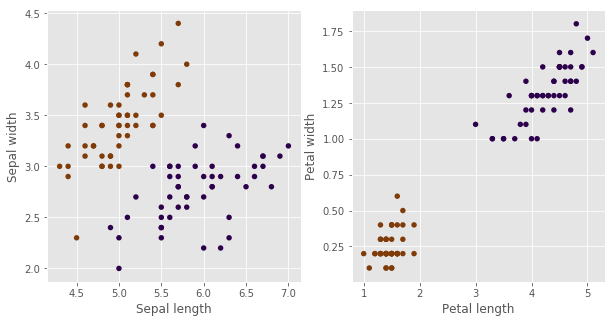

In [26]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [247]:
# Давайте проверим, как справляются sklearn реализации
sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print (" Sklearn AGGL score {}. Sklearn AGGL time {}".format(aggl_score, aggl_diff))

 Sklearn AGGL score 1.0. Sklearn AGGL time 0.004000425338745117


In [248]:
# Здесь предскажем кластера, посчитаем метрику кластеризации и время работы, сравним со склерном
сustum_aggl = Clustering(metric='euclidean', k=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("Our AGGL score {}. Our AGGL time {}".format(aggl_score, aggl_diff))

Our AGGL score 1.0. Our AGGL time 0.7410383224487305


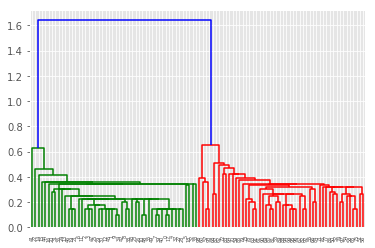

In [246]:
сustum_aggl.plot_dendrogram()

# Боевое применение (3  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для нашего конкурса!

Будем рассматривать каждую группу независимо от других групп. На каждой группе применим наш алгоритм и отрисуем денденограмму. По результатам кластерного анализа, Вам нужно ответить на следующие вопросы:

1) Можно ли по дендонаграмме (или по другим результатам кластеризации) сказать, где в группе аномалии? Каким образом?

2) Какое расстояние лучше использовать между заголовками страниц для кластеризации? Как еще учесть другую информацию о странице в расстоянии?

2) Какое качество f1_score Вы смогли получить на обучающем множестве методами кластеризации? (валидацию можете не делать, если таргет не используете)

4) Как можно результат кластеризации затем использовать для  финальной модели обучения с учителем?

Подсказка: самое важное - выбрать расстояние между заголовками. Самый простой вариант:  процент различных слов в двух заголовках. В семинаре мы рассматривали более сложный вариант, но Вы сможете придумать лучше. 

In [251]:
doc_to_title = {}
import io
with io.open('docs_titles.tsv', encoding='utf-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print(len(doc_to_title))

28026


In [252]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [351]:
traingroups_titledata[13]

[(12802, 'MyWarp', 1),
 (13058, 'Ответы@Mail.Ru: minecraft..', 1),
 (13630, 'Как создать warp в Minecraft?', 1),
 (11476, 'Варпы для всех » Excalibur-Craft 1.7.10', 0),
 (11547,
  'MyWarp - создаём варпы (спавны) на сервере - Плагины для сервера  - Все для minecraft, моды, текстуры, готовые сервера - World-Minecraft',
  1),
 (14339, "Warp'ы на сервере minecraft-city! - YouTube", 0),
 (13655, 'Крафт — Minecraft Wiki', 0),
 (13754, 'как создать warp в игре minecraft (Майнкрафт)', 1),
 (12121,
  'Как поставить точку варпа (Страница 1) — Архив — Форум Minecraft2000.ru',
  0),
 (11423, 'Как установить точку варпа с плагином MyWarp - YouTube', 1),
 (14709, '» Как ставить варп в minecraft', 1),
 (13787, 'Крафт — Minecraft Wiki', 0),
 (12450, 'Игровое сообщество MegaSeven', 0),
 (14649,
  'Ответы@Mail.Ru: как сделать варп на сервере майнкрафт как сделать варп на сервере майнкрафт',
  1),
 (11857,
  'Ответы@Mail.Ru: Что такое варп в майнкрафте? ( Я премиум игрок на лаунчере и имею право делать 

Кластеризацию проводите в каждой группе отдельно, то есть изучайте, можно ли в группе  найти подкластер выбросов

Документы можно представлять например словами из тайтла

Главное подобрать хорошую функцию расстояния между документами

Удачи! Все получится!

Замечание: в кластеризации можно использовать все данные, то есть трейн + тест, чтобы находить больше закономерностей 

In [375]:
mass = []
symbol = ['.', ',', '!', '?', ';', ':']
for q, a, j in traingroups_titledata[13]:
    text = [x for x in a.lower().split()]
    for i in range(len(text)):
        if text[i][-1:] in symbol:
            text[i] = text[i][:-1]
    text = [stemmer.stemWord(y) for y in set(text) if len(y) >= 3]
    mass.append(text)

In [376]:
сustum_aggl = Clustering(metric='for_project', k=2)
aggl_t0 = time.time()
aggl_pred = сustum_aggl.fit_predict(mass)
aggl_diff = time.time() - aggl_t0

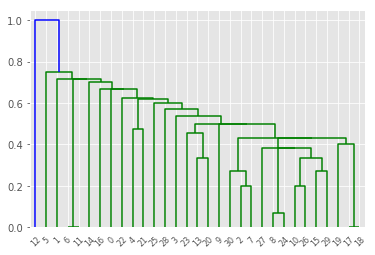

In [377]:
сustum_aggl.plot_dendrogram()

In [382]:
for q, (i, j, k) in enumerate(traingroups_titledata[13]):
    print(q, k)

0 1
1 1
2 1
3 0
4 1
5 0
6 0
7 1
8 0
9 1
10 1
11 0
12 0
13 1
14 0
15 0
16 1
17 1
18 1
19 1
20 0
21 1
22 0
23 0
24 0
25 0
26 0
27 0
28 1
29 0
30 1


Если получилось найти выбросы с помощью кластеризации, то не забывайте использовать его в финальном решении. Помните - использование различных подходов к решению задачи всегда улучшает финального качество.

Что-то не очень она разделяет их ((

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

Определение жанра / темы чего-либо, в рекомендательной системе.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

k-means: Быстро считается, предсказание для новых объектах, но число кластеров - структурный параметр, выбросы все ломают

dbscan: Находит выбросы, сам определяет число кластеров, можно предсказать для новых объектов, но нельзя дообучать и нужно выбирать самому параметры 

Агломеративная: Заданием только расстояния мы получаем все, на выходе любое число кластеров, но долго и нельзя дообучаться.

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

Правдоподобие может не быть ограниченным

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

Кластеризацию

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

Всем элементам кластера, куда попали размеченные элементы, приписать темтику размеченного элемента

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***